# Perzeptron

Das Single Layer Perzeptron ist das einfachste neuronale Netz, welches ein Feauture(Eingabe) nimmt, sie gewichtet daraus die weighted sum bildet und diese dann einer Aktivierungsfunktion übergibt. Das Ergbenis davon kann dann zu binären Klassifikation oder linearen regression verwendet werden. 
Es ist ein in idealer Startpunkt, um die Grundmechanik neuronaler Netzte zu verstehen, damit wir aufbauend darauf die Grundlagen des Kurses bilden.

### Reminder:
An geeigneten Stellen werde ich auf die Implementierungen in pytorch eingehen, aber unser Hauptaugenmerk liegt hier in der Theorie um ein fundiertes
Grundverständis aufzubauen.

### Ziel dieses Kapitels :
Wie verarbeitet ein Neuron Eingaben?

Wie beeinflussen Gewichte die Entscheidung?

Was bedeutet „linear trennbar“?

Und warum scheitert das Perzeptron an manchen Problemen – etwa XOR?

Dabei geht es nicht um die Nutzung einer Bibliothek, sondern darum zu verstehen, wie ein einzelnes künstliches Neuron tatsächlich arbeitet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path
import seaborn as sns
sns.set_theme() 
from illustration_utils.plot_image import show_illustration


In [2]:
rng = np.random.default_rng(seed=53)

## Generierung der Daten und Visualisierung
Zum Einstieg erstellen wir zunächst zweidimenionale Datenpunkten basierend auf den logischen Gattern **AND** / **OR**. Das ermöglicht eine klare visuelle Darstellung und zeigt uns unmittelbar, ob die Daten linear seperabel sind. 

Das von Rosenblatt entwickelte Perzeptron aus dem Jahr *1957* kann linear nicht seperable Daten wie das **XOR** Problem nicht lösen. Diese Eigenschaft machen wir uns zu Nutze und erzeugen linear trennbare und nicht trennbare Datensätze um die Funktionsweise und Grenzen des Modells sichtbar zu machen.



Erstellen der Feautures und Labels

In [3]:
# Feautures
X = np.array([[0,0],[0,1], [1,0], [1,1]], dtype=np.float64)
print(f"Feautures shape: {X.shape}")

# Labels
y_and = np.array([[0],[0],[0],[1]], dtype=np.float64)
y_or = np.array([[0],[1],[1],[1]], dtype=np.float64)

y = y_and
print(f"True y shape: {y.shape}")


Feautures shape: (4, 2)
True y shape: (4, 1)


Nun schauen wir uns die Visualisierung der Daten an, durch scharfes sehen ist erkennbar dass diese linear seperabel sind. Zu illustratorischen Zwecken zeichnen ich uns eine *fiktive* Entscheidungsgrenze ein. 

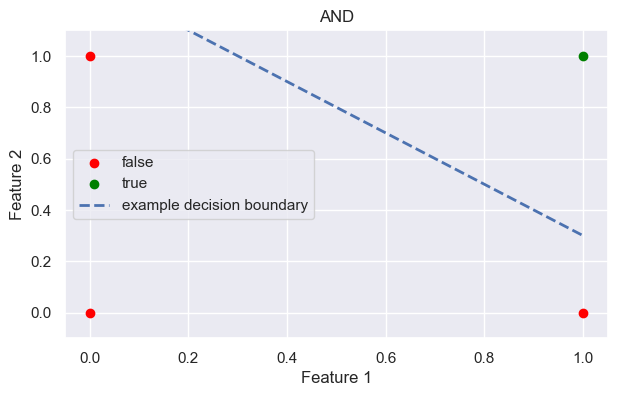

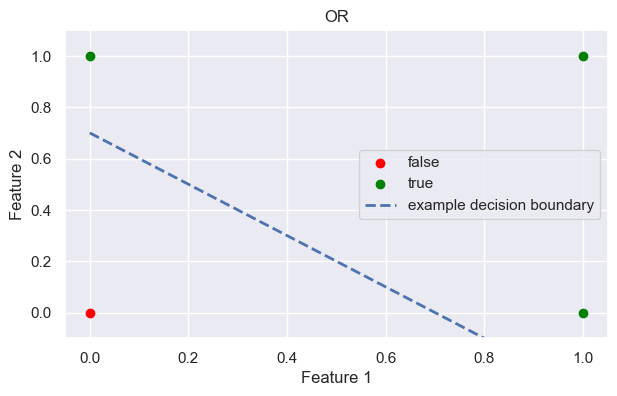

In [4]:
x_ = np.linspace(0,1,2)

def visualize_data(X: np.ndarray, y:np.ndarray, title:str):
    y = y.flatten()
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(X[y==0,0], X[y==0,1], color="red", label="false")
    ax.scatter(X[y==1,0], X[y==1,1], color="green", label="true")    
    ax.legend()
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_ylim(-0.1,1.1)
    ax.set_title(title)
    return fig, ax

def ex_boundary_helper(ax: plt.Axes, intercept:float, x:np.ndarray = x_) -> np.ndarray:
    y = -x + intercept
    ax.plot(x,y, ls="--", lw=2, label="example decision boundary")
    ax.legend()

fig1,ax1 = visualize_data(X, y_and, "AND")
ex_boundary_helper(ax1,1.3)
fig2,ax2 = visualize_data(X, y_or, "OR")
ex_boundary_helper(ax2,0.7)

## Das Perzeptron als Modell

Das Perzeptron verarbeitet Eingaben in drei aufeinanderfolgenden Schritten:

### 1. Eingabe
Das Modell erhält einen Eingabevektor **x**, den Featurevektor.

### 2. Berechnung
Die Eingabe wird über die Gewichte **w** und den Bias-Parameter **b** linear transformiert.
**z** nennen wir die gewichtete Summe:

$$z = \mathbf{w}^\top \mathbf{x} + b$$

### 3. Ausgabe
Die gewichtete Summe **z** übergeben wir einer nichtlinearen Aktivierungsfunktion, beim Rosenblatt Perceptron klassisch die Step Function. Beim Perzeptron nennen wir das Ergebnis davon die Prediction des Modells:

$$\hat{y} = \text{step}(z) = \begin{cases} 1 & \text{falls } z \geq 0 \\ 0 & \text{sonst} \end{cases}$$

### Vollständiger Datenfluss
Der gesamte Prozess lässt sich wie folgt darstellen:

$$\mathbf{x} \longrightarrow \mathbf{w}^\top \mathbf{x} + b \longrightarrow \text{step}(z) \longrightarrow \hat{y}$$

---

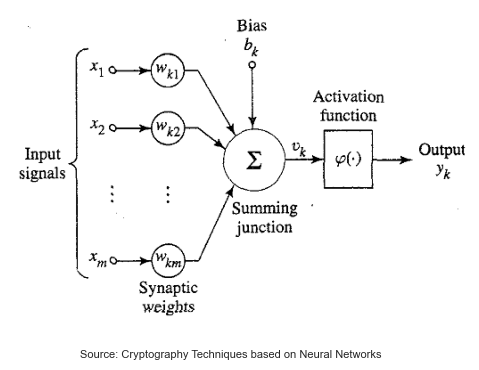

In [5]:
pth = Path("illustrations") / "beginner" / "perceptron"
fig3, ax3 = show_illustration(
    pth / "perceptron.ppm", pth / "perceptron_source.txt"
)


## Aktivierungsfunktion definieren

Neben der eben definierten Step Function, führen wir an dieser Stelle die **Sigmoid** Aktivierungsfunktion ebenfalls ein, welchen wir mit einer modifizierten Lernregel später für das Perzeptron und den Multi Layer Perzeptron verwenden. Im deep learning gibt es eine Vielzahl von verschiedenen Aktivierungen, einige werden wir uns im Verlauf anschauen.

Eine visuelle Inspektion verrät uns auf Anhieb schon einige Eigenschaften, welche direkt sichbar sind, zusätzlich gibt es *versteckte* Eigenschaften, welche man nicht durch das scharfe sehen direkt erkennt. Für uns ist das im Moment irrelevant, da wir erstmal eine Intuition zum Workflow bilden wollen. Wir werden das im Kapitel **Aktivierung** und **Featureraum** der *Beginnersektion* näher beleuchten und später umfassend in der *Intermidatesektion*. 

**Sigmoid:**
$$ f(x)=\frac{1}{1+e^{-x}} $$

Man erkennt auf Anhieb:
- Wertebereich liegt in **(0,1)**
- monoton steigend
- für große **|x|** nähert sich der Wert **0** oder **1** an
- stetig differenzierbar

Der Ausgabe der Sigmoid-Funktion kann eine Semantik mitgegeben werden. Für die Binärklassifikation bedeutet das:
- $\sigma(z) < 0.5$ → Klasse **0**
- $\sigma(z) >= 0.5$ → Klasse **1**


**Step Function:**

Man erkennt auf Anhieb:
- Werte können nur **0** oder **1** annehmen
- **x = 0** ist nicht definiert
- selbst wenn differenzierbar, Steigung = 0 -> kein nutzbarer Gradient -> kein Informationsgehalt

Anmerkung: 
Die 


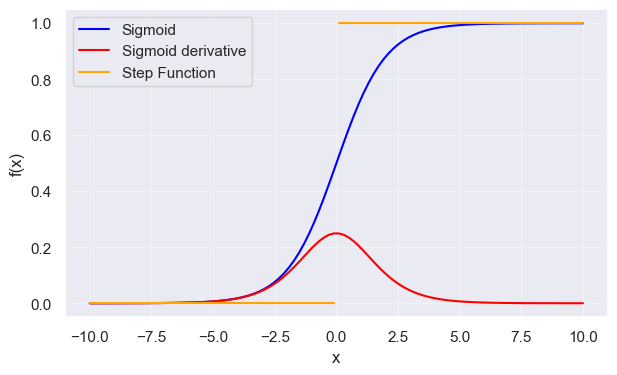

In [6]:
def step_function(x: np.ndarray):
  return np.where(x >= 0, 1, 0)

def sigmoid(x: np.ndarray):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x: np.ndarray):
  ds = (np.exp(-x))/(1+np.exp(-x))**2
  return ds

x = np.linspace(-10, 10, 100)
fig4, ax4 = plt.subplots(figsize=(7, 4))

ax4.plot(x, sigmoid(x), c="blue", label="Sigmoid")
ax4.plot(x, sigmoid_derivative(x), c="red", label="Sigmoid derivative")
ax4.plot(x[x < 0], step_function(x[x < 0]), c="orange", label="Step Function")
ax4.plot(x[x >= 0], step_function(x[x >= 0]), c="orange")

ax4.grid(alpha=0.3)
ax4.set_xlabel("x")
ax4.set_ylabel("f(x)")
ax4.legend();

#Todo delta (y-y_dach) einabuen in md
## Perzeptron-Klasse implementieren

Nun implementieren wir das Perzeptron als Klasse. Wir haben bereits die Architektur beleuchtet, nun widmen wir uns der Lernregel.

### Klassische Perzeptron-Lernregel

Das Perzeptron lernt, indem es seine Gewichte **nur dann** anpasst, wenn es einen Fehler macht.

Für jedes Trainingsbeispiel wird die Prediction $\hat{y}$ mit dem wahren Label $y$ verglichen.  
Daraus ergibt sich ein **Fehlerterm**:

$$
\delta = y - \hat{y}
$$

- Wenn $\delta = 0$:  
  Die Vorhersage ist korrekt → **keine** Anpassung.
- Wenn $\delta = 1$:  
  Das Perzeptron hat $0$ vorhergesagt, obwohl $1$ korrekt wäre →  
  Die Gewichte sollen in Richtung von $\mathbf{x}$ verschoben werden.
- Wenn $\delta = -1$:  
  Das Perzeptron hat $1$ vorhergesagt, obwohl $0$ korrekt wäre →  
  Die Gewichte sollen von $\mathbf{x}$ weg verschoben werden.

Die **klassische Perzeptron-Lernregel** lautet:

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta \, \delta \, \mathbf{x}
$$

$$
b \leftarrow b + \eta \, \delta
$$

wobei $\eta$ die Lernrate ist.

#### Intuition

- Falsch klassifizierte **positive** Beispiele ($y = 1$) „ziehen" den Gewichtsvektor in ihre Richtung.
- Falsch klassifizierte **negative** Beispiele ($y = 0$) „stoßen" den Gewichtsvektor von sich weg.
- Korrekt klassifizierte Beispiele haben keinen Einfluss auf die Gewichte.

Auf diese Weise verschiebt das Perzeptron seine Entscheidungsgrenze so lange, bis alle Trainingspunkte (falls linear separierbar) korrekt klassifiziert werden.

<!-- ## Perzeptron-Klasse implementieren
Nun implementieren wir das Perzeptron als Klasse. Wir haben bereits die Architektur beleuchtet nun widmen wir uns der Lernregel. 
### Klassische Perzeptron-Lernregel

Das Perzeptron lernt, indem es seine Gewichte **nur dann** anpasst, wenn es einen Fehler macht.  

Für jedes Trainingsbeispiel wird die Prediction $$\hat{y}$$ mit dem wahren Label $$y$$ verglichen.  
Daraus ergibt sich ein **Fehlerterm**:

\[
\delta = y - \hat{y}
\]

- Wenn \( \delta = 0 \):  
  Die Vorhersage ist korrekt → **keine** Anpassung.
- Wenn \( \delta = 1 \):  
  Das Perzeptron hat \(0\) vorhergesagt, obwohl \(1\) korrekt wäre →  
  Die Gewichte sollen in Richtung von \(\mathbf{x}\) verschoben werden.
- Wenn \( \delta = -1 \):  
  Das Perzeptron hat \(1\) vorhergesagt, obwohl \(0\) korrekt wäre →  
  Die Gewichte sollen von \(\mathbf{x}\) weg verschoben werden.

Die **klassische Perzeptron-Lernregel** lautet dann:

\[
\mathbf{w} \leftarrow \mathbf{w} + \eta \, \delta \, \mathbf{x}
\]

\[
b \leftarrow b + \eta \, \delta
\]

wobei \(\eta > 0\) die Lernrate ist.

#### Intuition

- Falsch klassifizierte **positive** Beispiele (\(y = 1\)) „ziehen“ den Gewichtsvektor in ihre Richtung.  
- Falsch klassifizierte **negative** Beispiele (\(y = 0\)) „stoßen“ den Gewichtsvektor von sich weg.  
- Korrekt klassifizierte Beispiele haben keinen Einfluss auf die Gewichte.

Auf diese Weise verschiebt das Perzeptron seine Entscheidungsgrenze so lange, bis alle Trainingspunkte (falls linear separierbar) korrekt klassifiziert werden.
 -->


In [ ]:
class Perzeptron:
    def __init__(self, input_size, activation_function):

        self.weight = rng.normal(size=(input_size,1))
        self.bias = 0.
        self.activation = activation_function

    def forward(self, X):
        """
        Berechnet die Ausgabe des Perzeptrons für ein Feauture X.

        Args:
            X: Eingabedaten, Shape (n_samples, n_features)

        Returns:
            Ausgabe des Perzeptrons nach Aktiverung, Shape (n_samples, 1)
        """
        z = X @ self.weight + self.bias
        a = self.activation(z)
        return a

    def train(self, X, y , lr=0.1, epochs=1000):
        """
        Trains the perceptron using the perceptron (error-count) learning rule.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
            y (np.ndarray): Target labels of shape (n_samples, 1) 
            lr (float): Learning rate
            epochs (int): Maximum number of training epochs.

        Returns:
            list[float]: List of error_rate per epoch
        """
    
        error_history = []

        for epoch in range(epochs):
            fehler_count = 0
            for xi, yi in zip(X,y):
                xi, yi = np.reshape(xi, (1,-1)) , np.reshape(yi, (-1,1))

                #Berechnung der Ausgabe
                y_hat = self.forward(xi)

                #Berechnung des Delta
                delta = (yi - y_hat)
                delta = np.squeeze(delta)
                delta = float(delta)

                #Update der Gewichte und des Bias
                if delta != 0:
                    self.weight += lr * delta * xi.T
                    self.bias += lr * delta
                    fehler_count += 1

            update_rate = fehler_count/len(y)
            error_rate = np.mean(y != y_hat)
            error_history.append(error_rate)

            if epoch % 10 == 0:
                print(f'Epoche {epoch}: Verlust = {error_rate:.4f}')

            if fehler_count == 0:
                print(f"Lösung in Epoche {epoch}")
                return error_history
                
        return error_history


## Das primäre Problem

Wir bauen im Laufe des Kurses viele verschiedene Architekturen von Scratch nach. 
Diese Architekturen werden immer komplexer, und wir werden nicht darum 
herumkommen, uns mit Bugs und noch schlimmer mit „hidden“ Fehlern zu beschäftigen, 
die durch falsche Shapes oder unerwartetes NumPy-Broadcasting entstehen. 

Broadcasting kann uns das Leben zwar stark erleichtern und ist oft gut darin zu erraten, 
was wir meinen, zum Beispiel in einer Zeile wie `z = X @ self.w + self.b`. 
Aber genau das kann auch dazu führen, dass wir Fehler erst sehr spät entdecken, 
weil der Code zwar läuft, aber stillschweigend etwas anderes tut als gedacht.

Leider haben wir hier nur die Präsentationsschicht, nicht das was live bei mir passiert,
deshalb, hier mein persönliches „Go-to“, um die Frustration etwas zu senken 
(ich laufe trotzdem gelegentlich in Bugs rein 😅): (Falls ihr Verbesserungen für mich habt ich bin offen dafür!!!)

In unserem Workflow haben wir grob: **Daten erstellen → Modell definieren → Training**.

1. **Shapes der Daten inspizieren**  
   Schau dir die Shapes von `X` und `y` an:  
   Entsprechen sie wirklich dem, was du im Kopf hast?  
   Z.B. `X.shape == (n_samples, n_features)`, `y.shape == (n_samples, 1)`.

2. **Shapes des Modells prüfen**  
   Kontrolliere `w`, `b` und die Ausgabe von `forward`:  
   Passen die Dimensionen zu deinen Daten? Gibt es offensichtliche Inkonsistenzen?

3. **Docstrings + Shape-Konventionen festhalten**  
   Schreib in den Docstring jeder Methode, mit welchen Shapes sie arbeitet  
   (z.B. „X: (n_samples, n_features), Rückgabe: (n_samples, 1)“)  
   und halte dich daran. Ich habe oben ein kleines Beispiel gegeben.

4. **Dummy-Forward-Pass**  
   Mach einen einzelnen Forward-Pass mit kleinen Dummy-Daten  
   (z.B. 1–2 Samples) und prüfe nur die Shapes der Zwischenwerte:  
   `print(X.shape, w.shape, z.shape, a.shape, ...)`.

5. **Assertions & Prints im Training (erstmal nur 1 Epoche)**  
   Lass den Trainingsloop zuerst nur **eine Epoche** oder sogar nur **einen Batch** laufen.  
   Baue unmengen an `assert`-Statements ein (z.B. `assert y.shape == y_hat.shape`)  
   und debug-Prints, um zu prüfen, ob die Berechnungen stimmen.

6. **Klein anfangen**  
   Teste neue Architektur-Ideen zuerst mit kleinen Beispieldaten/Modellarchitekturen 


In [8]:
def test_train(test:Perzeptron, X:np.ndarray, y:np.ndarray , lr=0.1, epochs=1000):
    """
    Trains the perceptron using the perceptron (error-count) learning rule.

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        y (np.ndarray): Target labels of shape (n_samples, 1) 
        lr (float): Learning rate
        epochs (int): Maximum number of training epochs.

    Returns:
        list[float]: List of losses per epoch
    """
    loss_history = []
    fehler_count = 0

    # Checks for loop
    print("=== Dummy train loop debug ===")
    print(f"X.shape = {X.shape}")
    print(f"y.shape = {y.shape}")
    assert X.ndim == 2, "X should be 2D: (n_samples, n_features)"
    assert y.ndim == 2, "y should be 2D"

    assert X.shape[0] == y.shape[0], "X and y must have the same number of samples"

    print(f"test.w.shape = {test.weight.shape}")
    print(f"test.b type  = {type(test.bias)}")
    print("===============================")

    for i, (xi, yi) in enumerate(zip(X, y)):
        print(f"\n--- Sample {i} ---")
        xi = np.reshape(xi, (1, -1))   # (1, n_features)
        yi = np.reshape(yi, (-1, 1))   # (1, 1)

        print(f"xi.shape: {xi.shape}, yi.shape: {yi.shape}")
        print(f"xi: {xi}")
        print(f"yi: {yi}")

        # Forward-Pass
        y_hat = test.forward(xi)
        print(f"y_hat.shape: {y_hat.shape}")
        print(f"y_hat: {y_hat}")

        assert yi.shape == (1, 1)
        assert yi.shape == y_hat.shape, "yi and y_hat must have the same shape"
        # correctness of step function
        assert np.all((y_hat == 0) | (y_hat == 1)), "y_hat should be 0 or 1 for step activation"

        # Loss / Delta
        delta = yi - y_hat
        print(f"delta: {delta}, shape: {delta.shape}")
        delta = np.squeeze(delta)
        delta = float(delta)
        
        # Update
        if delta != 0:
            print("updating parameters")
            print(f"w before: {test.weight}")
            print(f"b before: {test.bias}")

            update_w = lr * delta * xi.T    # (n_features, 1)
            print(f"update_w.shape: {update_w.shape}")
            assert update_w.shape == test.weight.shape

            test.weight += update_w
            test.bias += lr * delta

            print(f"w after:\n{test.weight}")
            print(f"b after: {test.bias}")

            fehler_count += 1
        else:
            print("Correct classification, no update")

    loss = fehler_count / len(y)
    loss_history.append(loss)
    print("=== End dummy train loop debug ===")


test_model = Perzeptron(X.shape[1], step_function)
test_train(test_model, X, y)

=== Dummy train loop debug ===
X.shape = (4, 2)
y.shape = (4, 1)
test.w.shape = (2, 1)
test.b type  = <class 'float'>

--- Sample 0 ---
xi.shape: (1, 2), yi.shape: (1, 1)
xi: [[0. 0.]]
yi: [[0.]]
y_hat.shape: (1, 1)
y_hat: [[1]]
delta: [[-1.]], shape: (1, 1)
updating parameters
w before: [[ 0.10468166]
 [-0.80654531]]
b before: 0.0
update_w.shape: (2, 1)
w after:
[[ 0.10468166]
 [-0.80654531]]
b after: -0.1

--- Sample 1 ---
xi.shape: (1, 2), yi.shape: (1, 1)
xi: [[0. 1.]]
yi: [[0.]]
y_hat.shape: (1, 1)
y_hat: [[0]]
delta: [[0.]], shape: (1, 1)
Correct classification, no update

--- Sample 2 ---
xi.shape: (1, 2), yi.shape: (1, 1)
xi: [[1. 0.]]
yi: [[0.]]
y_hat.shape: (1, 1)
y_hat: [[1]]
delta: [[-1.]], shape: (1, 1)
updating parameters
w before: [[ 0.10468166]
 [-0.80654531]]
b before: -0.1
update_w.shape: (2, 1)
w after:
[[ 0.00468166]
 [-0.80654531]]
b after: -0.2

--- Sample 3 ---
xi.shape: (1, 2), yi.shape: (1, 1)
xi: [[1. 1.]]
yi: [[1.]]
y_hat.shape: (1, 1)
y_hat: [[0]]
delta: [[1

### Perzeptron trainieren

Jetzt können wir das Modell auf unseren AND/OR-Daten trainieren.  
Dabei interessiert uns nicht nur, **ob** das Perzeptron am Ende alles richtig klassifiziert, sondern auch, **wie** sich die Fehlerrate (Error Rate) über die Epochen entwickelt.  
Die Error Rate ist dabei einfach der Anteil der Trainingsbeispiele, die in einer Epoche falsch klassifiziert wurden.  
Dafür visualisieren wir den Verlauf der Error Rate während des Trainings.


In [9]:
def visualize_training(loss_history):
    epochs = np.arange(1, len(loss_history) + 1)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(epochs,loss_history, label="Error rate")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error rate")
    ax.set_title("Training progress")

    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()
    return fig, ax

Epoche 0: Verlust = 0.7500
Epoche 10: Verlust = 0.2500
Lösung in Epoche 14


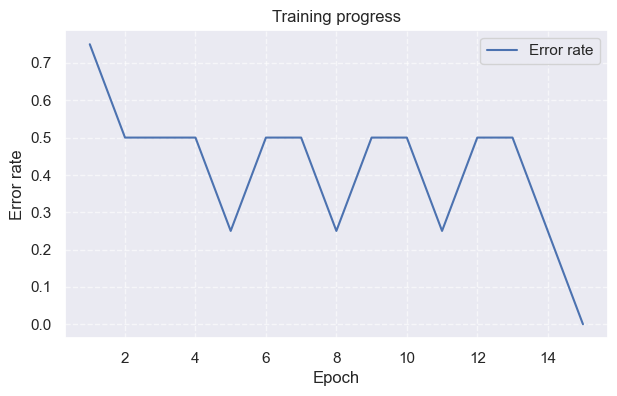

In [10]:
input_size = X.shape[1]
model = Perzeptron(input_size, step_function)
loss_history = model.train(X, y, lr=0.1, epochs=100)
fig5, ax5 = visualize_training(loss_history)

## Ergebnisse auswerten
Nun schauen wir uns an wie das trainierte Perzeptron auf die Eingabedaten reagiert.
Manchen Lesern wird sofort klar sein, dass die Predictions und Erwartete Ausgabe identisch sein müssen,
da eine Lösung vor der Abbruchbedinung gefunden wurde. 
Die Error rate für dieses Modell kann nur die Werte:
**1** (max Fehlerzähler/4)
**0.75** 3/ 4
**0.5** 2/4
**0.25** 1/4
**0** 0/4
annehmen  

In [11]:
predictions = model.forward(X)
print("Eingaben und Vorhersagen:")
for i in range(len(X)):
    print(f"Eingabe: {X[i]}, Erwartete Ausgabe: {y[i]}, Vorhersage: {predictions[i]}")

Eingaben und Vorhersagen:
Eingabe: [0. 0.], Erwartete Ausgabe: [0.], Vorhersage: [0]
Eingabe: [0. 1.], Erwartete Ausgabe: [0.], Vorhersage: [0]
Eingabe: [1. 0.], Erwartete Ausgabe: [0.], Vorhersage: [0]
Eingabe: [1. 1.], Erwartete Ausgabe: [1.], Vorhersage: [1]


## Das mathematische Modell
Das trainierte Perzeptron können wir und als Funktion ausgeben lassen. Das dient zur Verständnisbildung, denn neuronale Netze egal ob tief oder nicht sind nichts anderes als mathematische Modelle. 
Weil das Perzeptron so simpel ist kann man sich das ausgeben lassen, normalerweise untersucht man die gelernten gewichte und den bias. Aber das machen wir in einem späterem Kapitel.

In [12]:
w_flat = model.weight.flatten()  
w1, w2 = w_flat
b = model.bias
print(f"f(x1,x2) = step({w1:.3f}*x1 + {w2:.3f}*x2 + {b:.3f})")

f(x1,x2) = step(0.492*x1 + 0.071*x2 + -0.500)


### Entscheidungsgrenze visualisieren
Die **Entscheidungsgrenze** ist hier die Gerade im Feature-Raum, an der das Perzeptron von Klasse 0
auf Klasse 1 „umschaltet“. Für ein Perzeptron mit zwei Eingaben ist das eine Gerade, die wir bereits oben beschrieben haben.

Wir visualisieren die Entscheidungsgrenze, indem wir auf einem Raster von Punkten (meshgrid) die Vorhersagen des Modells berechnen und mit `contourf` darstellen. Dadurch sieht man:

- Die Vorhersage springt von **0 auf 1**. Es gibt keine Werte dazwischen, das sehen wir auch durch die colorbar.
- Die Grenze wirkt immer **treppenförmiger** mit kleinerem n, weil wir nur auf einem  Gitter auswerten. Das widerspricht auf dem erstem Blick der definierten Funktion, aber dass sind halt die Grenzen eines Plotters. Bei meinem eigenem Funktionsplotter den ich programmiert hatte, hatte ich ebenfalls das selbe Problem. 

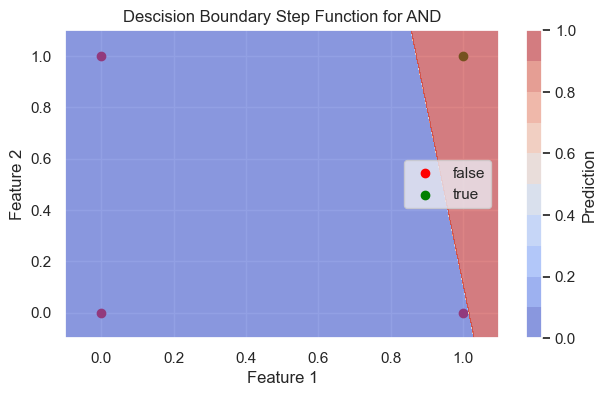

In [13]:
n = 1000
x1 = np.linspace(-0.1, 1.1, n)
x2 = np.linspace(-0.1, 1.1, n)
x1_grid, x2_grid = np.meshgrid(x1, x2)
X_viz = np.c_[x1_grid.flatten(), x2_grid.flatten()]
assert X_viz.shape == (n*n, 2), (
    "Shape Mismatch for forward pass -> expect shape (samplesize,2)"
    )

y_viz = model.forward(X_viz).reshape(n,-1)
fig6, ax6 = visualize_data(X,y,"Descision Boundary Step Function for AND")
cf = ax6.contourf(x1_grid, x2_grid, y_viz, levels=10, cmap='coolwarm', alpha=0.6)
fig6.colorbar(cf, label="Prediction");

## Training für das OR-Problem
Inspizieren wir das auch für das Or-Problem. Da dies wie zu Beginn festgestellt ebenfalls linear seperabel ist,wird ebenfalls eine Lösung gefunden.

Epoche 0: Verlust = 0.7500
Epoche 10: Verlust = 0.5000
Lösung in Epoche 14


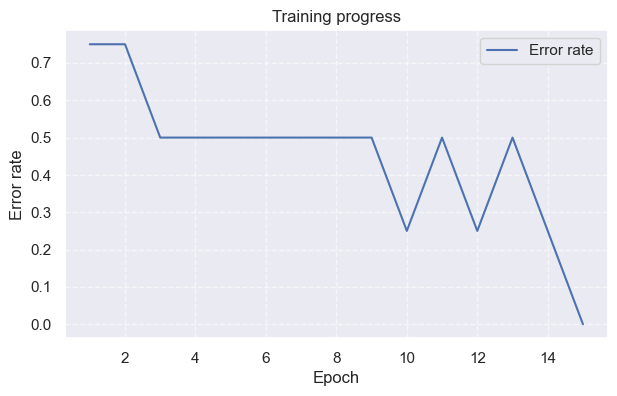

In [14]:
y = y_or
model = Perzeptron(input_size,activation_function=step_function)
loss_history = model.train(X, y, lr=0.1, epochs=100)
fig7, ax7 = visualize_training(loss_history)

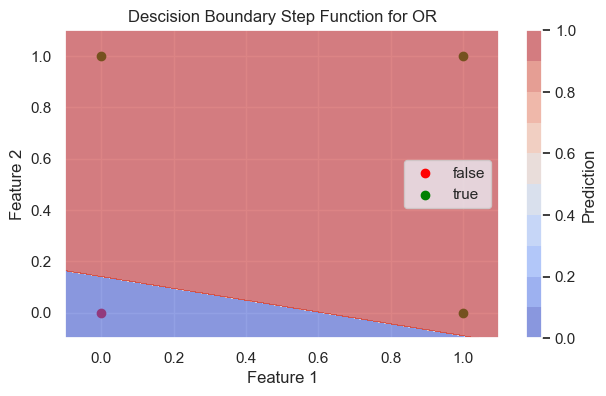

In [15]:
y_viz = model.forward(X_viz).reshape(n,-1)
fig8, ax8 = visualize_data(X,y,"Descision Boundary Step Function for OR")
cf = ax8.contourf(x1_grid, x2_grid, y_viz, levels=10, cmap='coolwarm', alpha=0.6)
fig8.colorbar(cf, label="Prediction");

## Problem Xor
Bis jetzt haben wir uns das Verhalten des Perzeptrons für linear seperable Daten angeschaut, wir schauen uns nun die Grenzen des Perzeptrons an, indem wir das zu Beginn erwähnte Problem replizieren. Beim visualisieren der Daten wird sehr schnell klar, dass wir keine lineare decision boundary finden können, welche die Daten linear trennt. Die niedrigst erreichbare Error Rate ist **0.25** außerdem konvergiert das Perzeptron zu einer Error Rate von **1**.

y_xor shape: (4, 1)


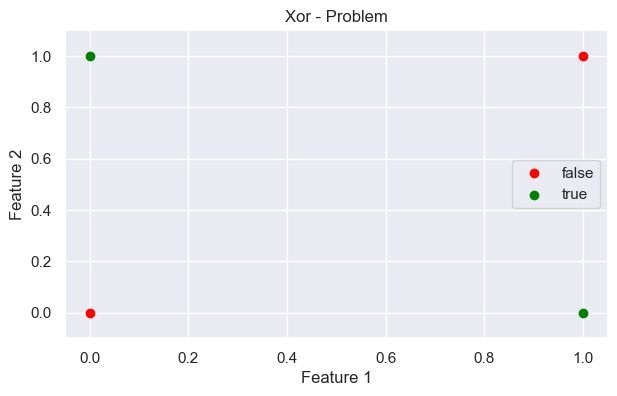

In [16]:
y_xor = np.array([[0],[1],[1],[0]], dtype=np.float64)
y = y_xor
print(f"y_xor shape: {y.shape}")
fig9, ax9 = visualize_data(X,y, "Xor - Problem")

Epoche 0: Verlust = 0.5000
Epoche 10: Verlust = 0.5000
Epoche 20: Verlust = 0.7500
Epoche 30: Verlust = 1.0000
Epoche 40: Verlust = 1.0000
Epoche 50: Verlust = 1.0000
Epoche 60: Verlust = 1.0000
Epoche 70: Verlust = 1.0000
Epoche 80: Verlust = 1.0000
Epoche 90: Verlust = 1.0000
[[-0.18094938]
 [-0.02418227]] 0.09999999999999998


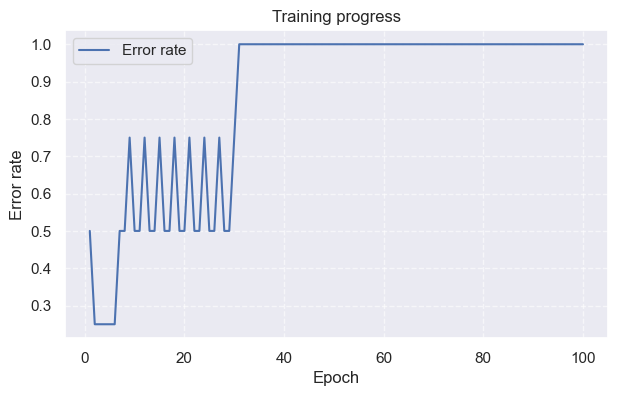

In [17]:
model = Perzeptron(input_size,activation_function=step_function)
loss_history = model.train(X, y, lr=0.1, epochs=100)
fig10, ax10 = visualize_training(loss_history)
print(model.weight,model.bias)

Schauen wir uns nun an, wieso wir die Errorrate gegen **1** konvergiert. Wir können uns eine Timelapse erstellen,
um das schnell zu veranschaulichen.

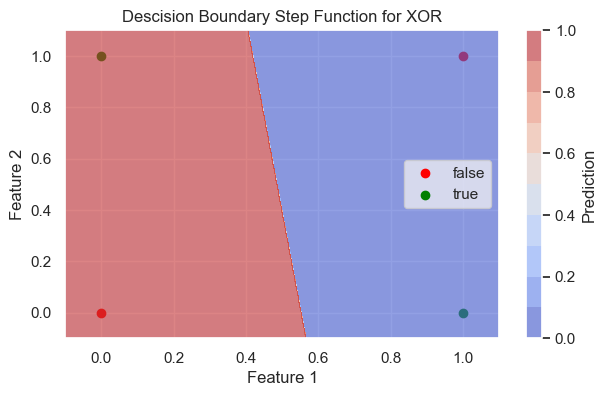

In [21]:
y_viz = model.forward(X_viz).reshape(n,-1)
fig11, ax11 = visualize_data(X,y,"Descision Boundary Step Function for XOR")
cf = ax11.contourf(x1_grid, x2_grid, y_viz, levels=10, cmap='coolwarm', alpha=0.6)
fig11.colorbar(cf, label="Prediction");